In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from collections import deque
import matplotlib.pyplot as plt
import glfw

observation = val_env.step(val_env.action_space.sample())[0]

reward = val_env.step(val_env.action_space.sample())[1]

terminated = val_env.step(val_env.action_space.sample())[2] # bool

truncated = val_env.step(val_env.action_space.sample())[3] # bool

info = val_env.step(val_env.action_space.sample())[4] # dict

dict_keys(['reward_linvel', 'reward_quadctrl', 'reward_alive', 'x_position', 'y_position', 'distance_from_origin', 'x_velocity', 'y_velocity', 'forward_reward'])

### Actor

In [6]:
class Actor(nn.Module) :
    def __init__(self, input_size, hidden_size, n_actions, lr, device=torch.device('cpu')):
        super(Actor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_actions = n_actions
        self.lr = lr
        self.device = device

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.fc1 = nn.Linear(
            in_features=self.input_size,
            out_features=self.hidden_size
        )

        self.fc2 = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.hidden_size
        )

        self.mean_fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features=self.n_actions
        )

        torch.nn.init.kaiming_normal_(self.mean_fc3.weight)

        self.log_std_fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features=self.n_actions
        )

        torch.nn.init.kaiming_normal_(self.log_std_fc3.weight)

        self.optimizer = optim.Adam(params=self.parameters(), lr=self.lr)

    def forward(self, x):

        x = x.float() # from float64 to float32

        x = self.relu(self.fc1(x))

        x = self.relu(self.fc2(x))

        mean = self.mean_fc3(x)

        clamped_log_std = torch.clamp(self.log_std_fc3(x), -20, 2) # clamp the log_std

        return mean, clamped_log_std   # mean, log_std
    
    def act(self, state, greedy=False):
        mean, log_std = self.forward(state)
        #   print('Mean: ', mean)
        #   print('Log_Std: ', log_std)

        action = self.tanh(mean)

        log_prob = None

        if not greedy: # explore
            
            # Apply Reparameterization Trick
            gaussian = Normal(0, 1)
            z = gaussian.sample()
            std = (log_std).exp()
            action = self.tanh(mean + std*z)
            
            log_prob = Normal(mean, std).log_prob(mean + std*z.to(self.device)+ 1e-6)
        
        return action, log_prob


### Critic

In [7]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, lr, device=torch.device('cpu')):
        super(Critic, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.device = device

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(
            in_features=self.input_size,
            out_features=self.hidden_size
        )

        self.fc2 = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.hidden_size
        )

        self.fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features= 1
        )

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

        self.criterion = nn.MSELoss()

    def forward(self, x):

        x = x.float() # from float64 to float32

        x = self.relu(self.fc1(x))

        x = self.relu(self.fc2(x))

        return self.fc3(x)

In [8]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action



### Algorithm

In [48]:
class Actor_Critic(nn.Module):
    def __init__(self, input_size, hidden_size, n_actions, act_lr, crt_lr, num_episodes, gamma, device=torch.device('cpu')):
        super(Actor_Critic, self).__init__()
        self.device = device

        self.num_episodes = num_episodes
        self.gamma = gamma

        self.Actor = Actor(
            input_size= input_size,
            hidden_size= hidden_size,
            n_actions= n_actions,
            lr= act_lr,
            device= self.device
        )

        self.Critic = Critic(
            input_size= input_size,
            hidden_size= hidden_size,
            lr= crt_lr,
            device= self.device
        )

        self.scheduler_actor_lr = optim.lr_scheduler.ReduceLROnPlateau(self.Actor.optimizer, factor=0.99, mode='min', patience=250, verbose=True)
        self.scheduler_critic_lr = optim.lr_scheduler.ReduceLROnPlateau(self.Critic.optimizer, factor=0.99, mode='min', patience=150, verbose=True)

    def save(self, model_name):
        torch.save(self.state_dict(), model_name + '.pt')

    def load(self, model_name):
        self.load_state_dict(torch.load(model_name + '.pt', map_location=self.device))

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret

    def train(self):

        E = NormalizedActions(gym.make(
            id='Humanoid-v4',            
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        ))
        

        scores = deque()
        scores_500 = deque(maxlen=500)
        act_losses = deque()
        crt_losses = deque()

        for iter in range(self.num_episodes):

        # CONTAINERS

            Rewards = []
            Log_prob = []
            Values = []
            obs_next = E.reset()[0]
            done_next = False

        # ROLLOUT
            t = 0

            while not done_next:

            #obs = torch.from_numpy(obs_next)
            #done = done_next

                action, log_prob = self.Actor.act(torch.from_numpy(obs_next))

                # print(action)
                value = self.Critic.forward(torch.from_numpy(obs_next))

                obs_next, reward, terminated, truncated, info = E.step(action.detach().numpy())
                
                Log_prob.append(log_prob)
                Values.append(value)
                Rewards.append(reward)

                done_next = terminated or truncated

                t+=1 # update counter

            scores.append(sum(Rewards))
            scores_500.append(sum(Rewards))

            Values.append(self.Critic.forward(torch.from_numpy(obs_next))) # this is my last value 

            #   print('Mean Score: ',np.mean(scores))

        # LEARNING

            #print(Log_prob)
            #print(t)

            Log_prob = torch.stack(Log_prob)
            # print(Log_prob.shape)
            Values = torch.stack(Values).squeeze()

            #   print('Values: ',Values.shape)
            #   print('Rewards: ',len(Rewards))
            #   print(t)

            # compute Advantage with TD Error
            
            Advantage = torch.zeros(t)

            for a in range(t+1): # t+1 = Values.shape[0] and t = len(Rewards)
                if a != (t):
                    Advantage[a] = Rewards[a] + self.gamma*Values[a+1] - Values[a]

            Return = torch.zeros(t+1)                    
            
            # policy gradient
            actor_loss = (- Log_prob.T @ Advantage.detach()).mean()

            #   natural gradient = F^-1 * policy gradient
            #   F = self.Fisher_Info_matrix(Log_prob)
            #   print(F.shape)
            #   natural_gradient = torch.inverse(F) * actor_loss


            critic_loss = self.Critic.criterion(Values[:-1], Advantage)

            act_losses.append(actor_loss.item())
            #   print('Actor Loss: ', actor_loss)
            crt_losses.append(critic_loss.item())
            #   print('Critic Loss: ', critic_loss)

        # UPDATES

            # Actor
            self.Actor.optimizer.zero_grad()
            actor_loss.backward()
            self.Actor.optimizer.step()
            self.scheduler_actor_lr.step(actor_loss)

            # Critic
            self.Critic.optimizer.zero_grad()
            critic_loss.backward()
            self.Critic.optimizer.step()
            self.scheduler_critic_lr.step(critic_loss)

        # SAVE


            if iter % 500 == 0:

                print(f'''Episode {iter}
                    \tAverage Score: {np.mean(scores_500)}
                    \tAverage Actor Loss: {np.mean(act_losses)}
                    \tAverage Critic Loss: {np.mean(crt_losses)}
                    \tLast Score: {sum(Rewards)}\n''')
                
            if iter % 5000 == 0:
                model_name = 'model_' + str((iter % self.num_episodes) // 5000)
                self.save(model_name)

        return act_losses, crt_losses, scores

### Evaluation

In [12]:
def Evaluate_Humanoid(agent, n_eval_episodes):
    rewards = []

    agent.load('final')

    val_env = NormalizedActions(gym.make(
        id='Humanoid-v4',
        terminate_when_unhealthy = True,
        exclude_current_positions_from_observation=False,
        render_mode = 'human',
    ))

    for n_episode in range(n_eval_episodes):
        episode_rewards = 0
        obs = val_env.reset()[0]
        done = False

        while not done:
            
            action, _ = agent.Actor.act(torch.from_numpy(obs), greedy=True)
            # print(action)
            # action = torch.sqrt(action+0.4) - 0.4
            #print(action)
            obs_next, rew, terminated, truncated, info = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated or truncated
            episode_rewards += rew
            obs = obs_next

        print('Reward episode %d: %d' %(n_episode, episode_rewards))

        rewards.append(episode_rewards)

    print('Mean Reward: ', np.mean(rewards))
    glfw.terminate() # close Mujoco render

In [26]:
def Previous_Episodes(agent):

    val_env = NormalizedActions(gym.make(
        id='Humanoid-v4',
        terminate_when_unhealthy = True,
        exclude_current_positions_from_observation=False,
        render_mode = 'human',
    ))
    num = agent.num_episodes // 5000  # change this value in order to have 3/4 previous model 
    print(num)
    for n_model in range(num):
        agent.load('model_'+str(n_model))

        episode_rewards = 0
        obs = val_env.reset()[0]
        done = False

        while not done:
            
            action, _ = agent.Actor.act(torch.from_numpy(obs), greedy=True)
            #print(action)
            obs_next, rew, terminated, truncated, info = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated or truncated
            episode_rewards += rew
            obs = obs_next

        print('Reward at %d: %d' %(n_model*5000, episode_rewards))
        
    glfw.terminate() # close Mujoco render

### Training and Testing

In [49]:
agent = Actor_Critic(
    input_size= 378,
    hidden_size= 32,
    n_actions= 17,
    act_lr= 2e-2,
    crt_lr= 1e-2,
    num_episodes= 40000,
    gamma=0.95
)

act_losses, crt_losses, scores_rew = agent.train()
agent.save('final')

Episode 0
                    	Average Score: 154.26808989590177
                    	Average Actor Loss: 1356375.375
                    	Average Critic Loss: 37.13275146484375
                    	Last Score: 154.26808989590177

Epoch 00290: reducing learning rate of group 0 to 1.9800e-02.
Episode 500
                    	Average Score: 134.39728071151288
                    	Average Actor Loss: 46489.6088519928
                    	Average Critic Loss: 6.907266848120177
                    	Last Score: 163.27112639270098

Epoch 00541: reducing learning rate of group 0 to 1.9602e-02.
Epoch 00649: reducing learning rate of group 0 to 9.9000e-03.
Epoch 00792: reducing learning rate of group 0 to 1.9406e-02.
Epoch 00940: reducing learning rate of group 0 to 9.8010e-03.
Episode 1000
                    	Average Score: 165.01251529769618
                    	Average Actor Loss: 25087.819985114373
                    	Average Critic Loss: 3.545655040066693
                    	Last Score: 

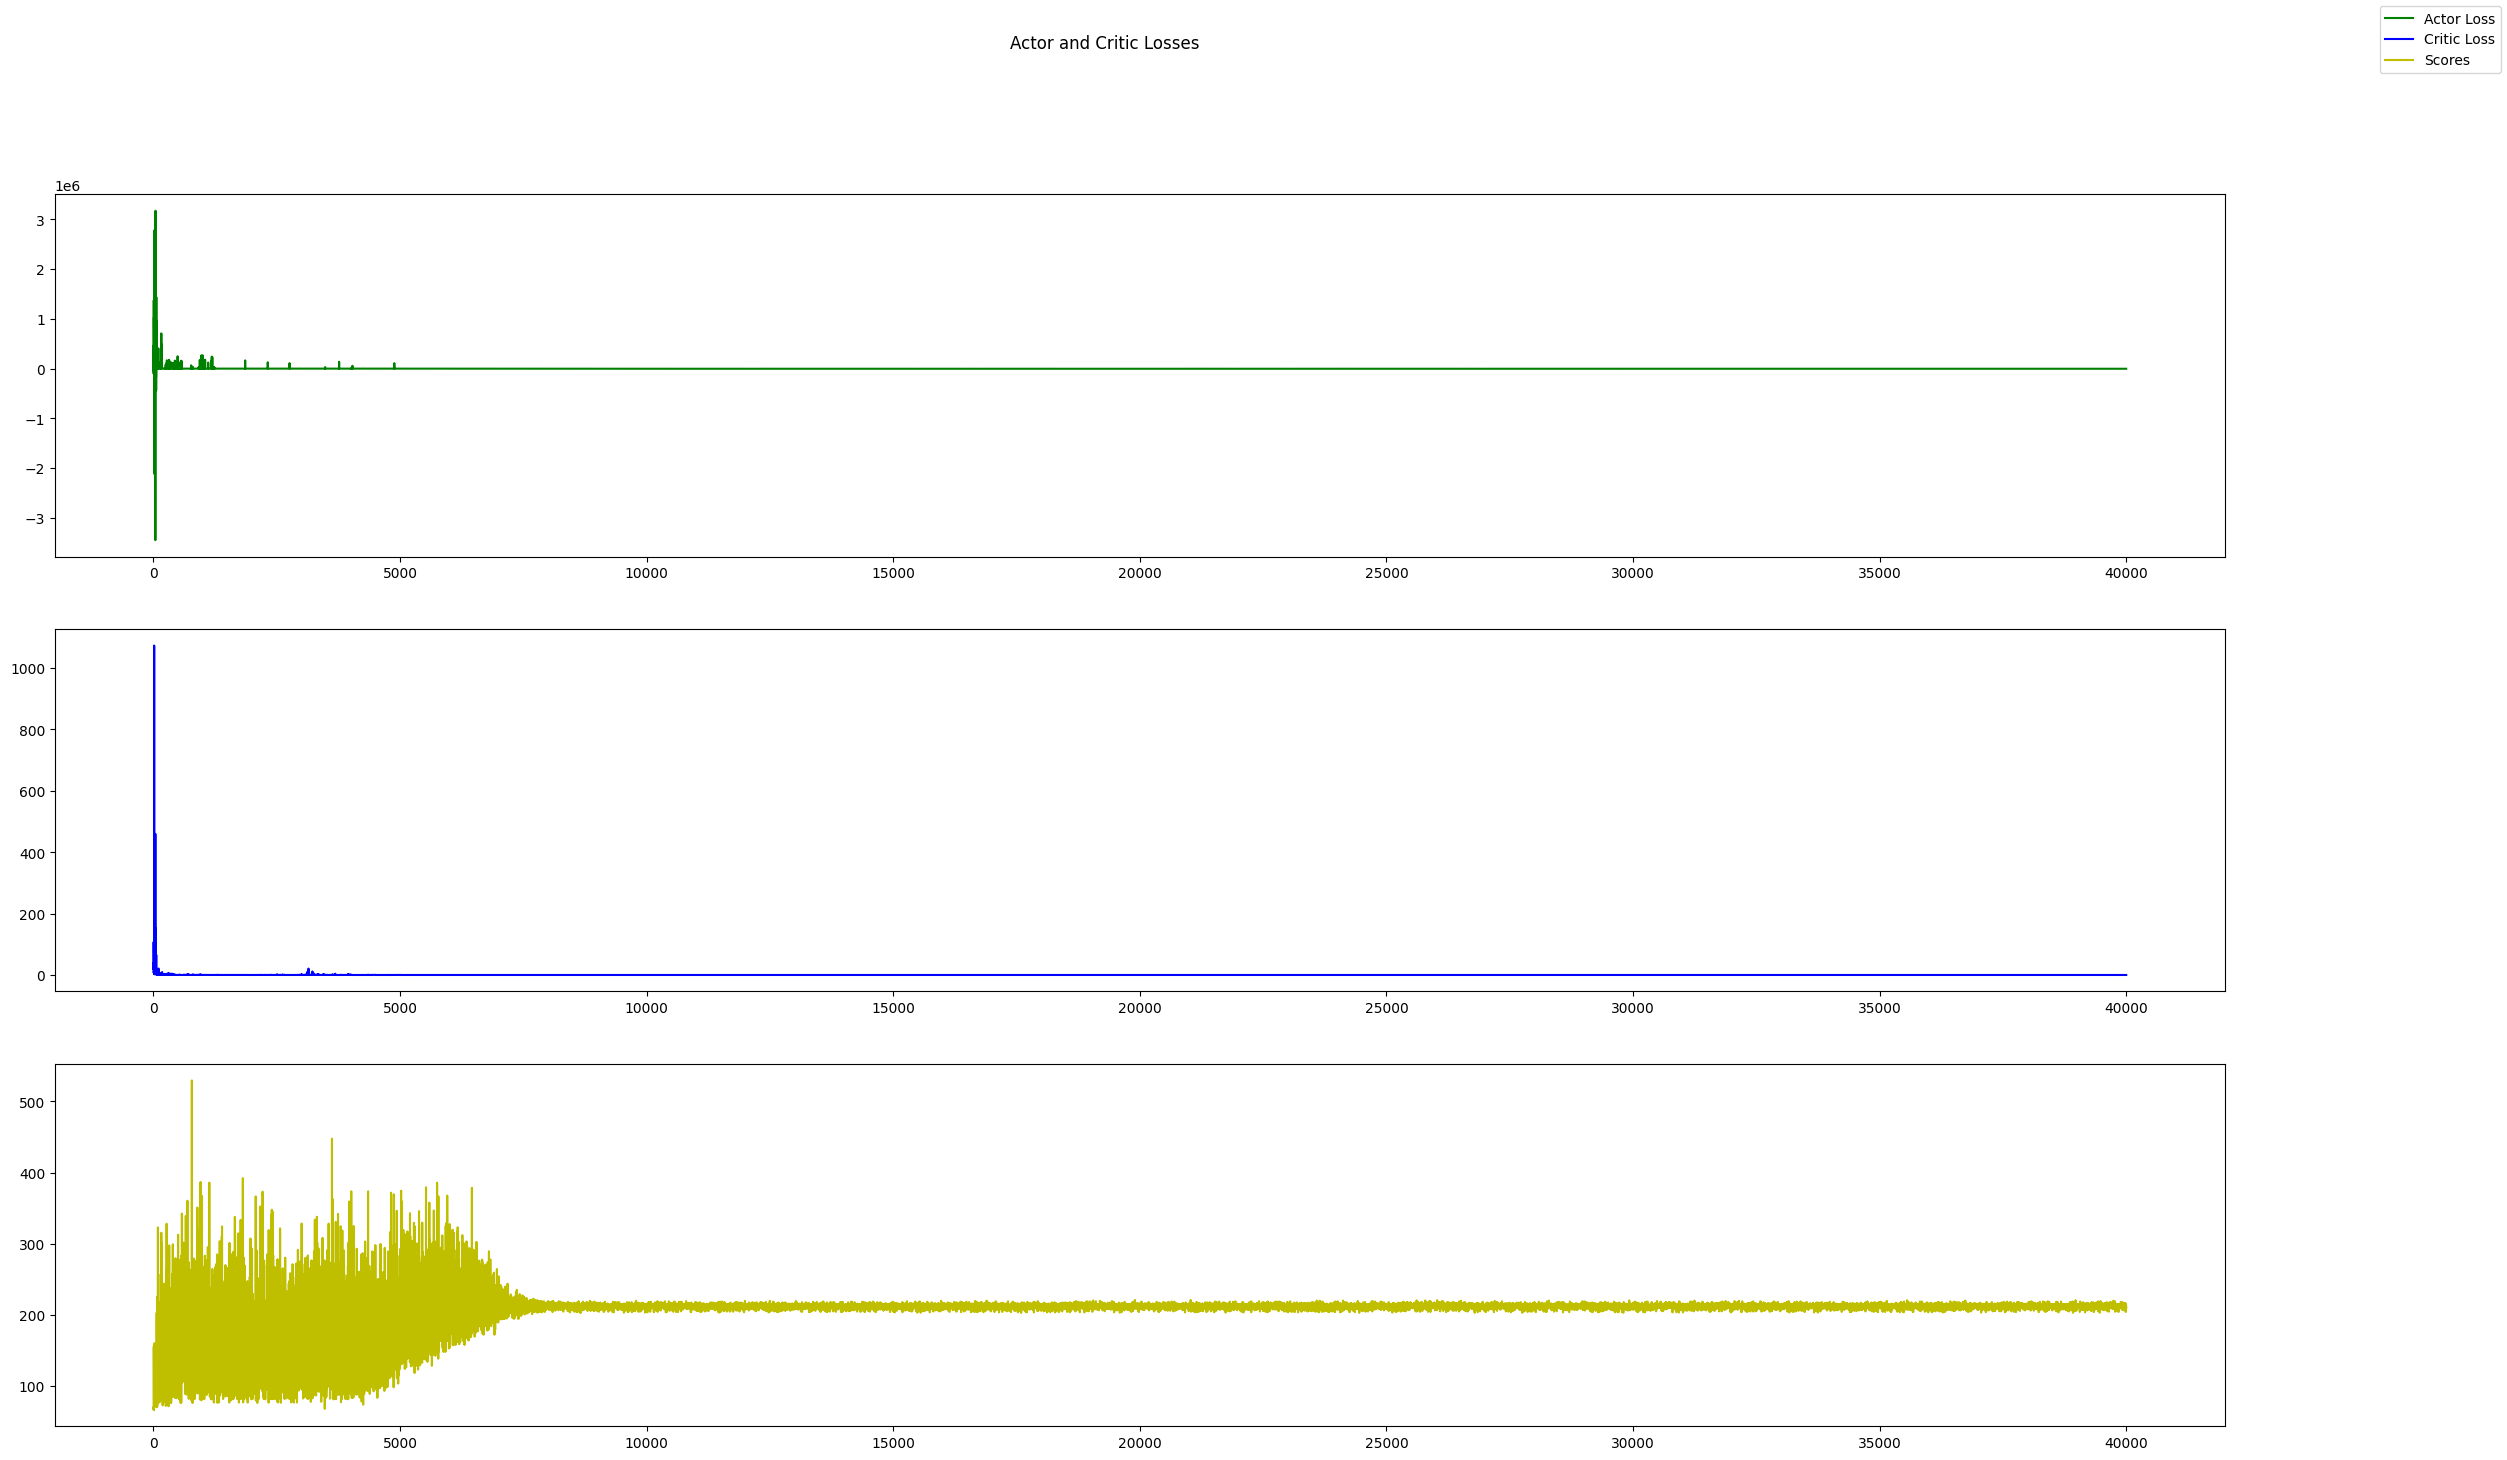

In [50]:
episodes = np.arange(1, agent.num_episodes + 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Actor and Critic Losses')

ax1.plot(episodes, act_losses, 'g', label='Actor Loss')

ax2.plot(episodes, crt_losses, 'b', label='Critic Loss')

ax3.plot(episodes, scores_rew, 'y', label='Scores')

fig.legend()
fig.set_figwidth(28)
fig.set_figheight(16)

In [51]:
Evaluate_Humanoid(agent, 10)

Reward episode 0: 213
Reward episode 1: 210
Reward episode 2: 213
Reward episode 3: 215
Reward episode 4: 211
Reward episode 5: 212
Reward episode 6: 210
Reward episode 7: 216
Reward episode 8: 213
Reward episode 9: 212
Mean Reward:  212.81147320165996


/home/brock/.local/lib/python3.10/site-packages/glfw/__init__.py:916: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


In [52]:
Previous_Episodes(agent)

8
Reward at 0: 77
Reward at 5000: 206
Reward at 10000: 212
Reward at 15000: 214
Reward at 20000: 211
Reward at 25000: 212
Reward at 30000: 210
Reward at 35000: 212
